In [4]:
from datetime import datetime
datetime.now().strftime("%d_%m_%Y_%H_%M_%S")

'12_05_2022_10_37_14'

In [5]:
# copy git repo and install requirements
# !git clone https://github.cNeuralLVM.git
# !pip install -r NeuralLVM/requirements.txtom/david-klindt/

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
# Load modules
import matplotlib.pyplot as plt
import numpy as np
import torch

from tests import StochasticNeurons
from utils import torch_circular_gp, analysis
from training import Trainer
from model import *

device = "cuda" if torch.cuda.is_available() else "cpu"
print('Running on', device)

Running on cuda
Running on cuda


# Basically the same as https://github.com/david-klindt/NeuralLVM/blob/main/tests.py#L126

In [17]:
# Set them paramz
num_ensemble=3
num_neuron_train=50
num_neuron_test=50
latent_dim=2
z_smoothness=3
num_sample=100000 // 100
num_test=10000
feature_type='bump'

In [18]:
# Make them dataz
num_neuron = num_neuron_train + num_neuron_test
neurons_train_ind = np.zeros(num_neuron * num_ensemble, dtype=bool)
ind = np.random.choice(
    num_neuron * num_ensemble,
    num_neuron_train * num_ensemble,
    replace=False
)
neurons_train_ind[ind] = True
model = StochasticNeurons(
    num_neuron, num_ensemble=num_ensemble, noise=True, latent_dim=latent_dim).to(device)

if z_smoothness > 0:  # gp latents
    z_train = torch_circular_gp(num_sample, latent_dim * num_ensemble, z_smoothness)
    z_test = torch_circular_gp(num_test, latent_dim * num_ensemble, z_smoothness)
else:  # iid latents
    z_train = torch.rand(num_sample, latent_dim * num_ensemble) * 2 * np.pi
    z_test = torch.rand(num_test, latent_dim * num_ensemble).to(device) * 2 * np.pi

z_train = z_train.to(device)
z_test = z_test.to(device)
data_train = model(z_train).detach()
model.noise = False
data_test = model(z_test).detach()
model.noise = True

(torch.return_types.min(
 values=tensor([-3.1375, -3.1384, -3.1403, -3.1308, -3.1382, -3.1416], device='cuda:0'),
 indices=tensor([849, 607, 970, 986, 479,  81], device='cuda:0')),
 torch.return_types.max(
 values=tensor([3.1409, 3.1139, 3.1396, 3.1414, 3.1395, 3.1393], device='cuda:0'),
 indices=tensor([604, 138, 687, 994,  97, 998], device='cuda:0')),
 torch.Size([1000, 6]))

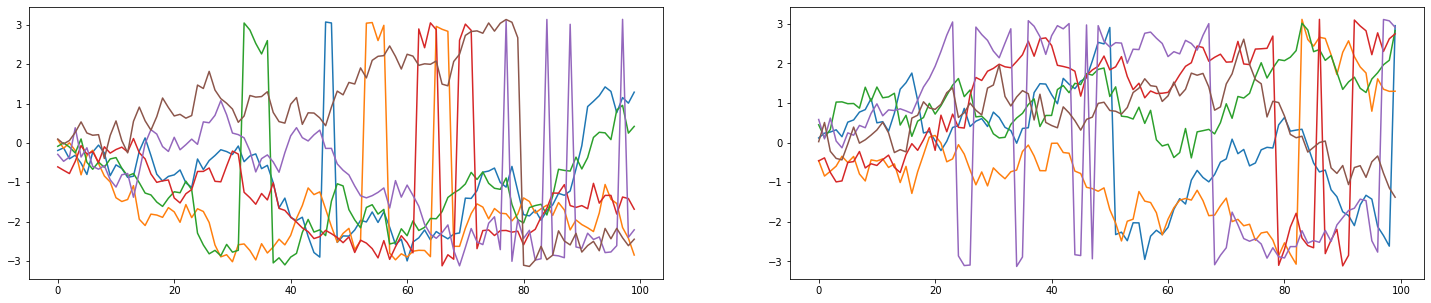

In [19]:
# latents
fig, axs = plt.subplots(1, 2, squeeze=False, figsize=(25, 5))

ax = axs[0, 0]
for i in range(z_train.shape[1]):
    ax.plot(z_train[:100, i].detach().cpu().numpy())
    
ax = axs[0, 1]
for i in range(z_train.shape[1]):
    ax.plot(z_test[:100, i].detach().cpu().numpy())
z_train.min(dim=0), z_train.max(dim=0), z_train.shape

In [20]:
# data
data_train.shape, data_test.shape

(torch.Size([300, 1000]), torch.Size([300, 10000]))

In [21]:
# Train that model
ensembler = LatentVariableModel(
    num_neuron_train=num_neuron_train * num_ensemble,
    num_neuron_test=num_neuron_test * num_ensemble,
    num_hidden=256,
    num_ensemble=num_ensemble,
    latent_dim=latent_dim,
    seed=234587,
    tuning_width=10.0,
    nonlinearity='exp',
    kernel_size=9,
    feature_type=feature_type,
    latent_style='hyper'   # 'hack' is default, better with hyper
).to(device)
print('model', ensembler)
print('number of trainable parameters in model:', (count_parameters(ensembler)))

kl_beta_mapper = {'hack': 1e-2, 'hyper': 3e-7}
trainer = Trainer(
    model=ensembler,
    data_train=data_train.cpu().numpy(),
    data_test=data_test.cpu().numpy(),
    neurons_train_ind=neurons_train_ind,
    mode='full',
    z_train=None,
    z_test=None,
    num_steps=50000,
    batch_size=128,
    seed=923683,
    learning_rate=3e-3,
    weight_kl= kl_beta_mapper[ensembler.latent_style],
)
trainer.train();

model LatentVariableModel(
  (encoder): Sequential(
    (0): Conv1d(150, 150, kernel_size=(9,), stride=(1,), padding=same, groups=150)
    (1): Conv1d(150, 256, kernel_size=(1,), stride=(1,), padding=same)
    (2): ReLU()
    (3): Conv1d(256, 256, kernel_size=(1,), stride=(1,), padding=same)
    (4): ReLU()
  )
  (mean_head): Conv1d(256, 12, kernel_size=(1,), stride=(1,), padding=same)
  (var_head): Conv1d(256, 6, kernel_size=(1,), stride=(1,), padding=same)
  (feature_basis): FeatureBasis()
)
number of trainable parameters in model: 113575


/home/scl1pal/.conda/envs/lvm/lib/python3.9/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'hyperspherical_vae.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


run=1000, running_loss=9.4457e+02, negLLH_train=9.4295e-01, negLLH_test=9.4458e-01, KL=3.14166951e+00, Slowness_loss=1.6262e-01, corr=0.136214, H=2.9652e-01, time=24.62
run=2000, running_loss=9.4066e+02, negLLH_train=9.4085e-01, negLLH_test=9.4270e-01, KL=3.61995792e+00, Slowness_loss=2.1845e-01, corr=0.321962, H=2.8657e-01, time=49.06
run=3000, running_loss=9.3867e+02, negLLH_train=9.3977e-01, negLLH_test=9.4194e-01, KL=3.80337644e+00, Slowness_loss=2.8755e-01, corr=0.392898, H=2.7869e-01, time=73.34
run=4000, running_loss=9.3767e+02, negLLH_train=9.3904e-01, negLLH_test=9.4138e-01, KL=3.87764907e+00, Slowness_loss=2.5724e-01, corr=0.450866, H=2.7587e-01, time=97.67
run=5000, running_loss=9.3641e+02, negLLH_train=9.3867e-01, negLLH_test=9.4038e-01, KL=4.04988527e+00, Slowness_loss=4.8429e-01, corr=0.550866, H=2.7977e-01, time=121.87
run=6000, running_loss=9.3544e+02, negLLH_train=9.3787e-01, negLLH_test=9.3940e-01, KL=4.15448618e+00, Slowness_loss=3.6984e-01, corr=0.602279, H=2.8396e-

KeyboardInterrupt: 

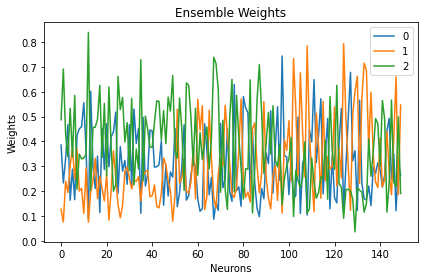

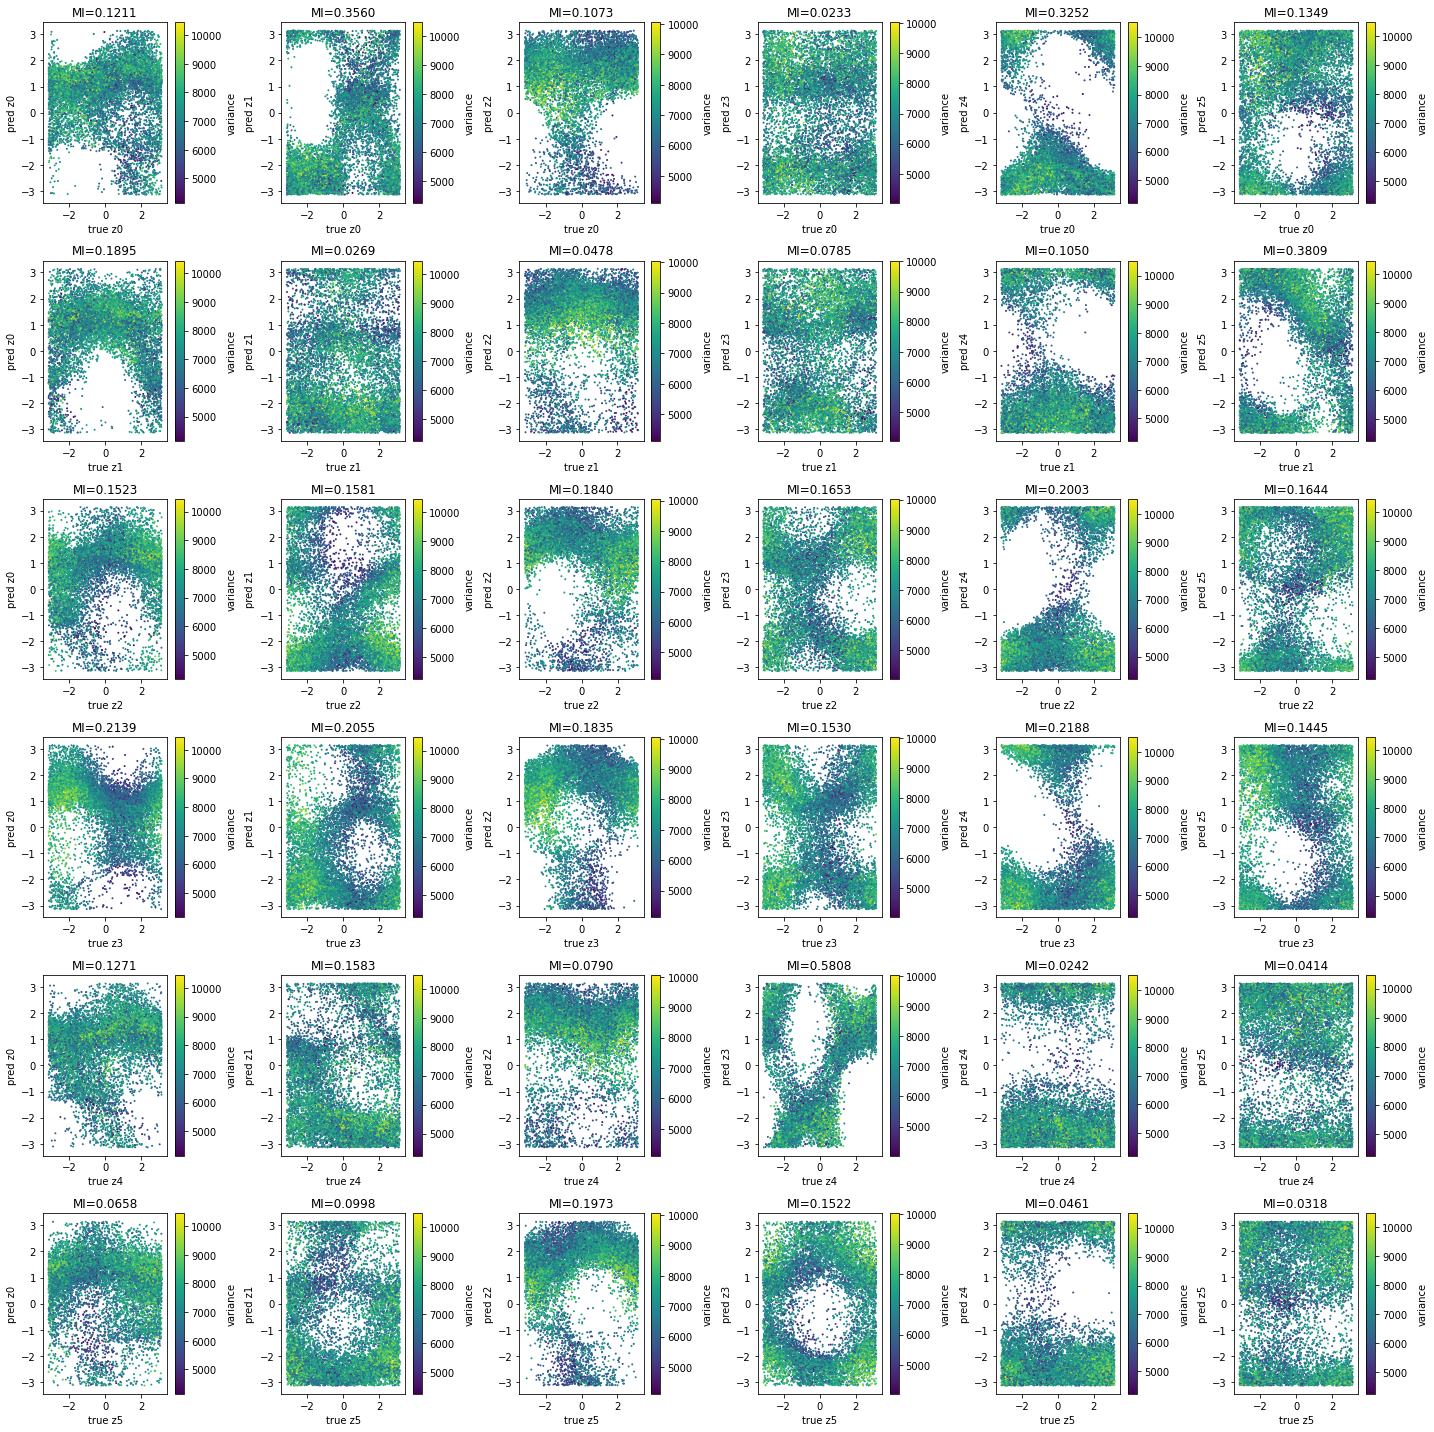

In [ ]:
# Analyze that model
analysis(ensembler, model, trainer, z_test)

### I can walk you though these plots over zoom =)

In [ ]:
# Repeat analysis with some sweet inference
# this is where the magic happens: https://github.com/david-klindt/NeuralLVM/blob/main/model.py#L369
analysis(ensembler, model, trainer, z_test, do_inference=True)

### Note how the latent prediction vs true (second figure) got narrower. And the response predictions (third figure) got better but also more biased in some cases..

#### Important: the inference should be done on the likelihood of the training neurons (on the test dataset). As you can see above, decresaing the negLLH on the training neurons also decreases the negLLH of the test neurons, so there seems to be no overfitting issue with this inference procedure.

#### Also, one might consider including the slowness prior (https://github.com/david-klindt/NeuralLVM/blob/main/training.py#L103) for better inference. Alternatively, at the moment I am optimizing 10 different seeds and then picking the best of those. Of course, without the slowness loss, one might make that more individual and pick the best value at each time point...

In [ ]:
# Train that model
ensembler = LatentVariableModel(
    num_neuron_train=num_neuron_train * num_ensemble,
    num_neuron_test=num_neuron_test * num_ensemble,
    num_hidden=256,
    num_ensemble=num_ensemble,
    latent_dim=latent_dim,
    seed=234587,
    tuning_width=10.0,
    nonlinearity='exp',
    kernel_size=9,
    feature_type=feature_type,
    latent_style='hyper'   # 'hack' is default, better with hyper
).to(device)
print('model', ensembler)
print('number of trainable parameters in model:', (count_parameters(ensembler)))

kl_beta_mapper = {'hack': 1e-2, 'hyper': 0}
trainer = Trainer(
    model=ensembler,
    data_train=data_train.cpu().numpy(),
    data_test=data_test.cpu().numpy(),
    neurons_train_ind=neurons_train_ind,
    mode='full',
    z_train=None,
    z_test=None,
    num_steps=50000,
    batch_size=128,
    seed=923683,
    learning_rate=3e-3,
    weight_kl= kl_beta_mapper[ensembler.latent_style],
)
trainer.train()

In [ ]:
# Analyze that model
analysis(ensembler, model, trainer, z_test)

/home/scl1pal/.conda/envs/lvm/lib/python3.9/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'hyperspherical_vae.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


INFERENCE: iter 0, negLLH(train): 0.9298851490020752, negLLH(test): 0.9300140142440796
INFERENCE: iter 100, negLLH(train): 0.9298693537712097, negLLH(test): 0.9299978017807007
INFERENCE: iter 200, negLLH(train): 0.9298681616783142, negLLH(test): 0.9299964308738708
INFERENCE: iter 300, negLLH(train): 0.9298681616783142, negLLH(test): 0.9299962520599365
INFERENCE: iter 400, negLLH(train): 0.9298681616783142, negLLH(test): 0.9299962520599365
INFERENCE: iter 500, negLLH(train): 0.9298681616783142, negLLH(test): 0.9299962520599365
INFERENCE: iter 600, negLLH(train): 0.9298681616783142, negLLH(test): 0.9299962520599365
INFERENCE: iter 700, negLLH(train): 0.9298681616783142, negLLH(test): 0.9299962520599365
INFERENCE: iter 800, negLLH(train): 0.9298681616783142, negLLH(test): 0.9299962520599365
INFERENCE: iter 900, negLLH(train): 0.9298681616783142, negLLH(test): 0.9299962520599365
INFERENCE: iter 1000, negLLH(train): 0.9298681616783142, negLLH(test): 0.9299962520599365
INFERENCE: iter 1100, 

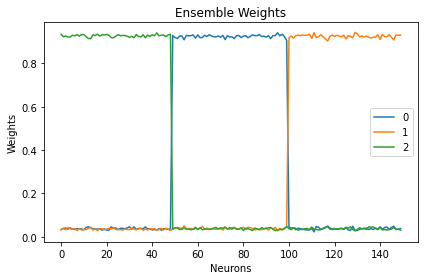

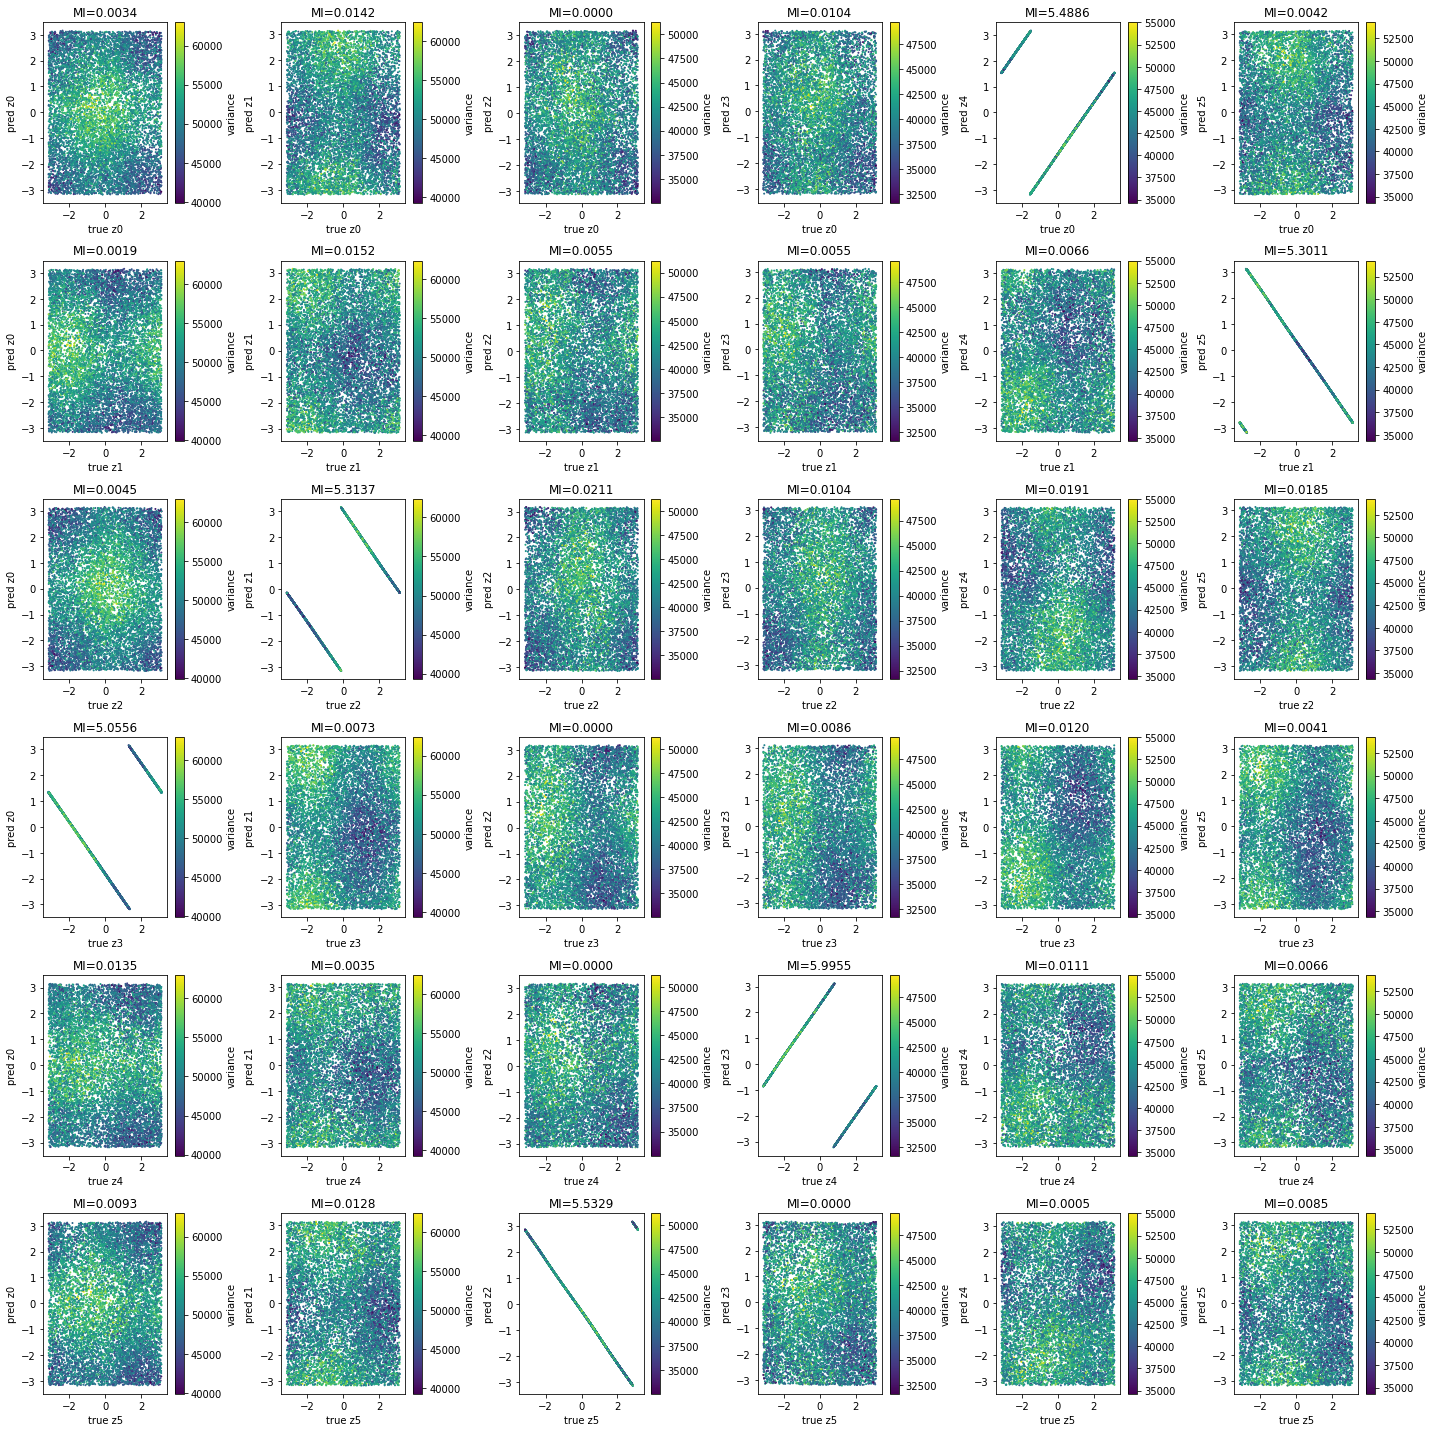

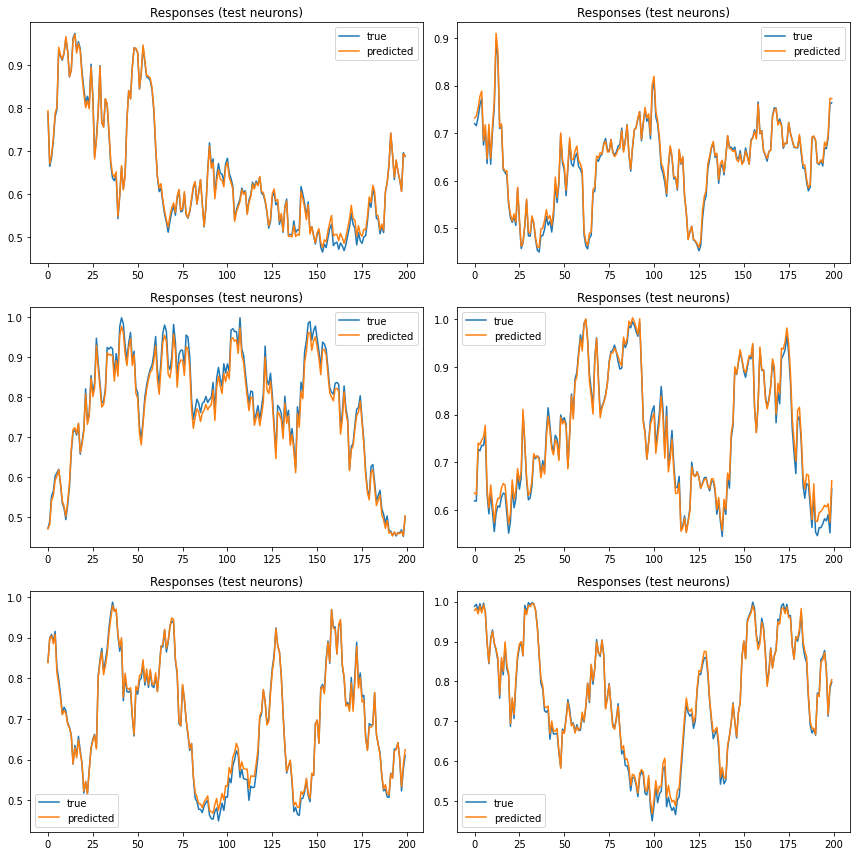

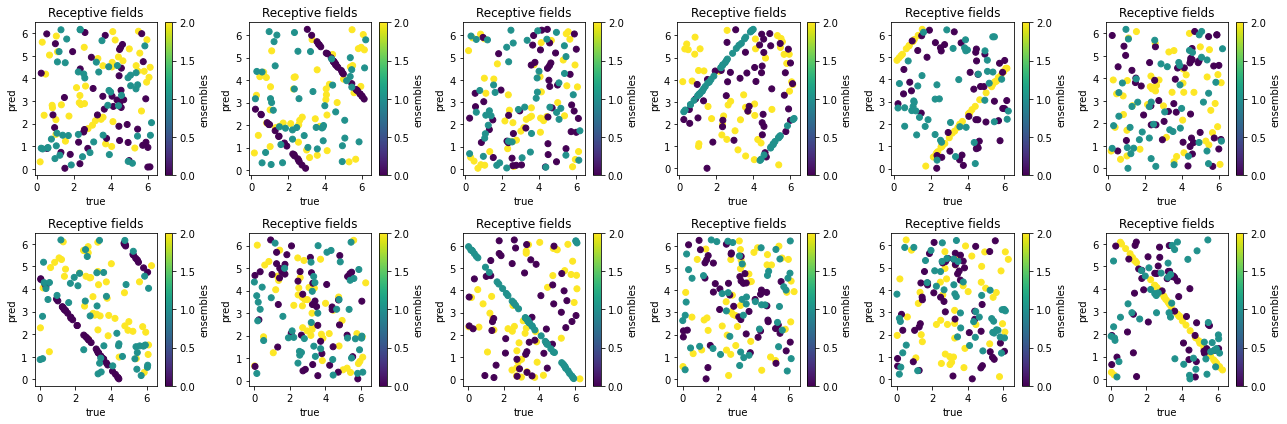

In [43]:
# Analyze that model
analysis(ensembler, model, trainer, z_test, do_inference=True)